In [2]:
import os

import pandas as pd
import numpy as np

from utils.plotting import plot_histogram_kde

from scipy import stats

import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

In [3]:
DATA_PATH = "../data"

In [4]:
os.listdir(DATA_PATH)

datasets = {}

for car in os.listdir(DATA_PATH):
    datasets[car] = {}

    for obd_type in os.listdir(DATA_PATH + "/" + car):
        datasets[car][obd_type] = {}

        for csv_file in os.listdir(DATA_PATH + "/" + car + "/" + obd_type):
            if "debug" in csv_file:
                datasets[car][obd_type]["debug"] = pd.read_csv(DATA_PATH + "/" + car + "/" + obd_type + "/" + csv_file)
            else:
                datasets[car][obd_type]["data"] = pd.read_csv(DATA_PATH + "/" + car + "/" + obd_type + "/" + csv_file)

# Data Analysis

## Polo

### OBD A

In [5]:
polo_a = datasets["polo"]["A"]["debug"]

polo_a.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739464440307,speed,0.0,513,1,1,0
1,1739464440839,rpm,981.0,131,2,2,0
2,1739464440972,engine_load,16.0,90,3,3,0
3,1739464441063,engine_oil_temperature,NO DATA\r>,149,4,4,1
4,1739464441213,coolant_temp,83.0,150,5,5,1
5,1739464441363,mass_air_flow,NO DATA\r>,148,6,6,2
6,1739464441511,throttle_position,17.0,149,7,7,2
7,1739464441660,voltage_control_module,13.33,94,8,8,2
8,1739464441755,fuel_level,47.84,149,9,9,2
9,1739464441904,fuel_pressure,NO DATA\r>,147,10,10,3


In [6]:
polo_a["Interval"].median()

np.float64(149.0)

In [7]:
polo_a.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        149.0
absolute_load_value                 150.0
absolute_throttle_pos_B             150.0
accelerator_pedal_pos_D             150.0
accelerator_pedal_pos_E             149.0
air_fuel_ratio                      149.0
catalyst_temp_bank1_sensor1         149.0
coolant_temp                        149.0
distance_traveled_with_MIL_on       149.0
engine_fuel_rate                    149.0
engine_load                         148.0
engine_oil_temperature              149.0
ethanol_percentage                  150.0
fuel_level                          149.0
fuel_pressure                       149.0
fuel_rail_gauge_pressure            149.0
fuel_rail_pressure                  149.0
intake_air_temperature              150.0
intake_manifold_absolut_pressure    150.0
mass_air_flow                       149.0
relative_throttle_pos               149.0
rpm                                 149.0
runtime_since_engine_start          149.0
speed                 

### OBD B

In [8]:
polo_b = datasets["polo"]["B"]["debug"]

polo_b.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739460036051,speed,0.0,257,1,1,0
1,1739460036051,speed,0.0,278,1,2,0
2,1739460036330,rpm,979.0,111,2,4,0
3,1739460036330,rpm,980.0,157,2,5,0
4,1739460036488,engine_load,15.0,133,3,7,0
5,1739460036488,engine_load,15.0,179,3,8,0
6,1739460036668,engine_oil_temperature,NO DATA,136,4,10,1
7,1739460036805,coolant_temp,NO DATA,137,5,12,2
8,1739460036943,mass_air_flow,NO DATA,129,6,14,3
9,1739460037074,throttle_position,16.0,180,7,16,3


In [9]:
polo_b["Interval"].median()

np.float64(178.0)

In [10]:
polo_b.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        178.0
absolute_load_value                 181.0
absolute_throttle_pos_B             179.0
accelerator_pedal_pos_D             180.0
accelerator_pedal_pos_E             181.0
air_fuel_ratio                      182.0
catalyst_temp_bank1_sensor1         178.0
coolant_temp                        181.0
distance_traveled_with_MIL_on       179.0
engine_fuel_rate                    132.0
engine_load                         178.0
engine_oil_temperature              132.0
ethanol_percentage                  177.0
fuel_level                          179.0
fuel_pressure                       133.0
fuel_rail_gauge_pressure            181.0
fuel_rail_pressure                  135.0
intake_air_temperature              178.0
intake_manifold_absolut_pressure    178.0
mass_air_flow                       135.0
relative_throttle_pos               178.0
rpm                                 176.0
runtime_since_engine_start          178.0
speed                 

### Plotting

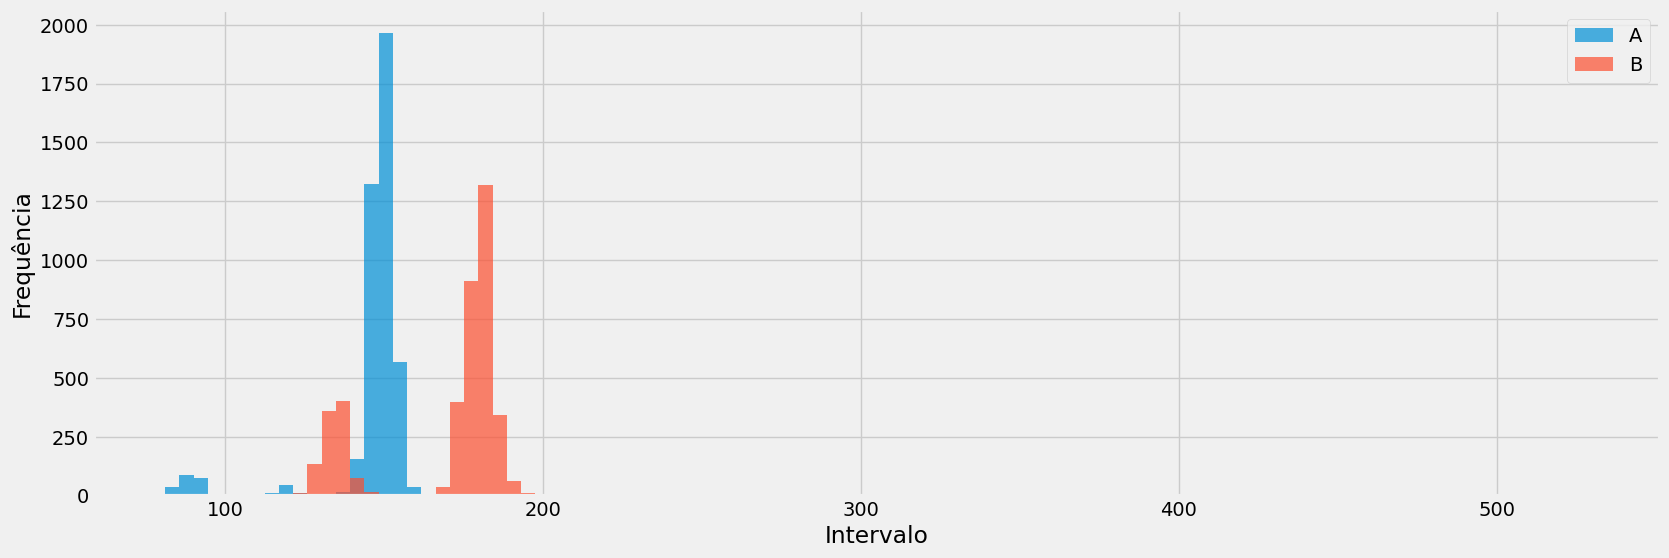

In [11]:
min_value = min(polo_a["Interval"].min(), polo_b["Interval"].min())
max_value = max(polo_a["Interval"].max(), polo_b["Interval"].max())

num_bins = 100
bins = np.linspace(min_value, max_value, num_bins + 1)

plt.figure(figsize=(18, 6))

plt.hist(polo_a["Interval"], bins=bins, alpha=0.7, label="A")
plt.hist(polo_b["Interval"], bins=bins, alpha=0.7, label="B")

plt.xlabel("Intervalo")
plt.ylabel("Frequência")

plt.legend(loc='upper right')

plt.show()

## Fit

### OBD A

In [12]:
fit_a = datasets["fit"]["A"]["debug"]

fit_a.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739465416416,speed,0.0,456,1,1,0
1,1739465416892,rpm,713.0,131,2,2,0
2,1739465417024,engine_load,22.0,148,3,3,0
3,1739465417173,engine_oil_temperature,NO DATA\r>,146,4,4,1
4,1739465417319,coolant_temp,86.0,153,5,5,1
5,1739465417472,mass_air_flow,1.68,147,6,6,1
6,1739465417620,throttle_position,15.0,149,7,7,1
7,1739465417769,voltage_control_module,14.13,153,8,8,1
8,1739465417922,fuel_level,65.49,147,9,9,1
9,1739465418069,fuel_pressure,NO DATA\r>,152,10,10,2


In [13]:
fit_a["Interval"].median()

np.float64(149.0)

In [14]:
fit_a.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        150.0
absolute_load_value                 148.0
absolute_throttle_pos_B             150.0
accelerator_pedal_pos_D             150.0
accelerator_pedal_pos_E             150.0
air_fuel_ratio                      150.0
catalyst_temp_bank1_sensor1         150.0
coolant_temp                        149.0
distance_traveled_with_MIL_on       150.0
engine_fuel_rate                    148.0
engine_load                         149.0
engine_oil_temperature              148.0
ethanol_percentage                  148.0
fuel_level                          149.0
fuel_pressure                       149.0
fuel_rail_gauge_pressure            150.0
fuel_rail_pressure                  148.0
intake_air_temperature              150.0
intake_manifold_absolut_pressure    150.0
mass_air_flow                       150.0
relative_throttle_pos               148.0
rpm                                 148.0
runtime_since_engine_start          149.0
speed                 

### OBD B

In [15]:
fit_b = datasets["fit"]["B"]["debug"]

fit_b.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739466128746,speed,0.0,159,1,1,0
1,1739466128948,rpm,743.0,135,2,3,0
2,1739466129133,engine_load,19.0,133,3,5,0
3,1739466129308,engine_oil_temperature,NO DATA,136,4,7,1
4,1739466129445,coolant_temp,90.0,135,5,9,1
5,1739466129623,mass_air_flow,1.59,135,6,11,1
6,1739466129803,throttle_position,14.0,137,7,13,1
7,1739466129983,voltage_control_module,14.1,136,8,15,1
8,1739466130165,fuel_level,65.1,134,9,17,1
9,1739466130344,fuel_pressure,NO DATA,139,10,19,2


In [16]:
fit_b["Interval"].median()

np.float64(136.0)

In [17]:
fit_b.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        136.0
absolute_load_value                 135.0
absolute_throttle_pos_B             137.0
accelerator_pedal_pos_D             136.0
accelerator_pedal_pos_E             136.0
air_fuel_ratio                      136.0
catalyst_temp_bank1_sensor1         136.0
coolant_temp                        134.5
distance_traveled_with_MIL_on       136.0
engine_fuel_rate                    136.0
engine_load                         135.0
engine_oil_temperature              136.0
ethanol_percentage                  136.0
fuel_level                          136.0
fuel_pressure                       136.0
fuel_rail_gauge_pressure            135.0
fuel_rail_pressure                  133.5
intake_air_temperature              136.0
intake_manifold_absolut_pressure    135.0
mass_air_flow                       136.0
relative_throttle_pos               136.0
rpm                                 136.0
runtime_since_engine_start          136.0
speed                 

### Plotting

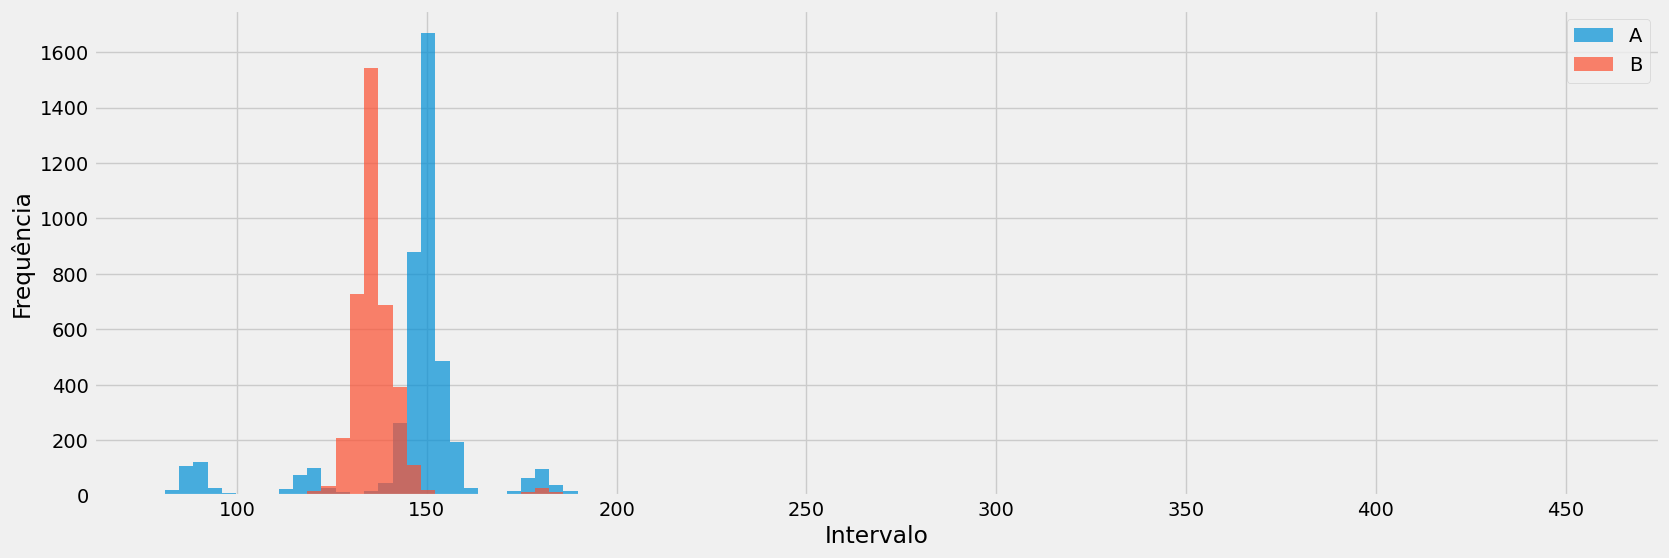

In [18]:
min_value = min(fit_a["Interval"].min(), fit_b["Interval"].min())
max_value = max(fit_a["Interval"].max(), fit_b["Interval"].max())

num_bins = 100
bins = np.linspace(min_value, max_value, num_bins + 1)

plt.figure(figsize=(18, 6))

plt.hist(fit_a["Interval"], bins=bins, alpha=0.7, label="A")
plt.hist(fit_b["Interval"], bins=bins, alpha=0.7, label="B")

plt.xlabel("Intervalo")
plt.ylabel("Frequência")

plt.legend(loc='upper right')

plt.show()

## Tcross

### OBD A

In [19]:
tcross_a = datasets["tcross"]["A"]["debug"]

tcross_a.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739468081274,speed,0.0,963,1,1,0
1,1739468082238,rpm,791.0,177,2,2,0
2,1739468082415,engine_load,31.0,119,3,3,0
3,1739468082535,engine_oil_temperature,NO DATA\r>,152,4,4,1
4,1739468082687,coolant_temp,87.0,148,5,5,1
5,1739468082835,mass_air_flow,2.03,150,6,6,1
6,1739468082985,throttle_position,17.0,152,7,7,1
7,1739468083137,voltage_control_module,12.68,149,8,8,1
8,1739468083286,fuel_level,51.76,150,9,9,1
9,1739468083436,fuel_pressure,NO DATA\r>,180,10,10,2


In [20]:
tcross_a["Interval"].median()

np.float64(150.0)

In [21]:
tcross_a.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        150.0
absolute_load_value                 150.0
absolute_throttle_pos_B             150.0
accelerator_pedal_pos_D             150.0
accelerator_pedal_pos_E             149.5
air_fuel_ratio                      150.0
catalyst_temp_bank1_sensor1         150.0
coolant_temp                        150.0
distance_traveled_with_MIL_on       150.0
engine_fuel_rate                    149.5
engine_load                         150.0
engine_oil_temperature              149.0
ethanol_percentage                  149.5
fuel_level                          150.0
fuel_pressure                       150.0
fuel_rail_gauge_pressure            150.0
fuel_rail_pressure                  150.0
intake_air_temperature              150.0
intake_manifold_absolut_pressure    150.0
mass_air_flow                       150.0
relative_throttle_pos               150.0
rpm                                 149.0
runtime_since_engine_start          149.0
speed                 

### OBD B

In [22]:
tcross_b = datasets["tcross"]["B"]["debug"]

tcross_b.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739468741420,speed,0.0,201,1,1,0
1,1739468741622,rpm,750.0,224,2,3,0
2,1739468741847,engine_load,33.0,271,3,5,0
3,1739468742119,engine_oil_temperature,NO DATA,222,4,7,1
4,1739468742343,coolant_temp,87.0,132,5,9,1
5,1739468742520,mass_air_flow,2.2,136,6,11,1
6,1739468742701,throttle_position,17.0,225,7,13,1
7,1739468743027,voltage_control_module,13.11,218,8,15,1
8,1739468743245,fuel_level,48.63,196,9,17,1
9,1739468743476,fuel_pressure,NO DATA,486,10,19,2


In [23]:
tcross_b["Interval"].median()

np.float64(169.0)

In [24]:
tcross_b.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        175.5
absolute_load_value                 177.0
absolute_throttle_pos_B             178.0
accelerator_pedal_pos_D             178.0
accelerator_pedal_pos_E             177.5
air_fuel_ratio                      177.0
catalyst_temp_bank1_sensor1         177.5
coolant_temp                        177.0
distance_traveled_with_MIL_on       178.0
engine_fuel_rate                    135.0
engine_load                         177.0
engine_oil_temperature              134.0
ethanol_percentage                  177.0
fuel_level                          177.0
fuel_pressure                       135.0
fuel_rail_gauge_pressure            135.0
fuel_rail_pressure                  135.0
intake_air_temperature              178.0
intake_manifold_absolut_pressure    135.0
mass_air_flow                       176.0
relative_throttle_pos               178.0
rpm                                 176.0
runtime_since_engine_start          177.0
speed                 

### Plotting

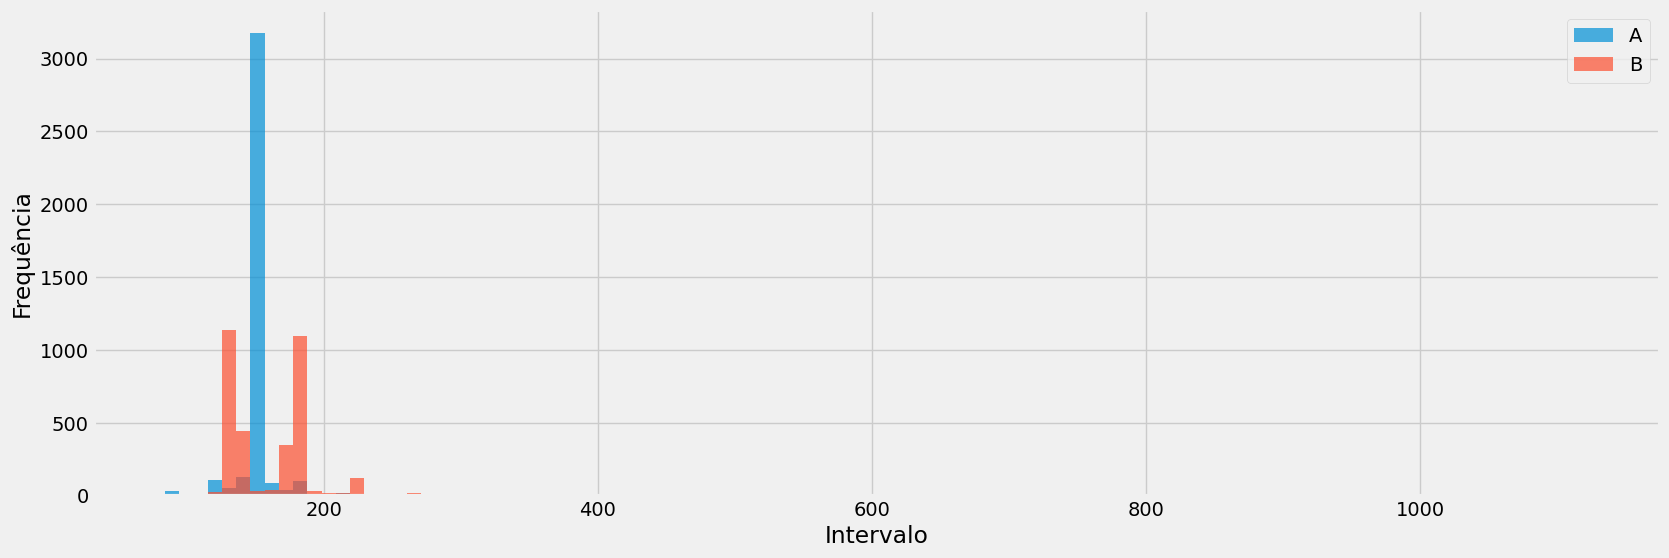

In [25]:
min_value = min(tcross_a["Interval"].min(), tcross_b["Interval"].min())
max_value = max(tcross_a["Interval"].max(), tcross_b["Interval"].max())

num_bins = 100
bins = np.linspace(min_value, max_value, num_bins + 1)

plt.figure(figsize=(18, 6))

plt.hist(tcross_a["Interval"], bins=bins, alpha=0.7, label="A")
plt.hist(tcross_b["Interval"], bins=bins, alpha=0.7, label="B")

plt.xlabel("Intervalo")
plt.ylabel("Frequência")

plt.legend(loc='upper right')

plt.show()

## HB20

### OBD A

In [26]:
hb20_a = datasets["hb20"]["A"]["debug"]

hb20_a.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739884777551,speed,0.0,355,1,1,0
1,1739884777907,rpm,844.0,148,2,2,0
2,1739884778055,engine_load,32.0,155,3,3,0
3,1739884778211,engine_oil_temperature,NO DATA\r>,148,4,4,1
4,1739884778359,coolant_temp,91.0,147,5,5,1
5,1739884778507,mass_air_flow,NO DATA\r>,151,6,6,2
6,1739884778658,throttle_position,13.0,147,7,7,2
7,1739884778806,voltage_control_module,14.18,151,8,8,2
8,1739884778957,fuel_level,29.02,151,9,9,2
9,1739884779109,fuel_pressure,NO DATA\r>,154,10,10,3


In [27]:
hb20_a["Interval"].median()

np.float64(137.0)

In [28]:
hb20_a.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        145.5
absolute_load_value                 116.5
absolute_throttle_pos_B             120.0
accelerator_pedal_pos_D             109.0
accelerator_pedal_pos_E             143.0
air_fuel_ratio                      138.5
catalyst_temp_bank1_sensor1         143.5
coolant_temp                        144.0
distance_traveled_with_MIL_on       118.5
engine_fuel_rate                    117.0
engine_load                         118.0
engine_oil_temperature              122.0
ethanol_percentage                  117.5
fuel_level                          142.0
fuel_pressure                       116.5
fuel_rail_gauge_pressure            146.0
fuel_rail_pressure                  142.5
intake_air_temperature              109.5
intake_manifold_absolut_pressure    142.0
mass_air_flow                       123.0
relative_throttle_pos               123.5
rpm                                 100.0
runtime_since_engine_start          139.5
speed                 

### OBD B

In [29]:
hb20_b = datasets["hb20"]["B"]["debug"]

hb20_b.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739885442664,speed,0.0,191,1,1,0
1,1739885442855,rpm,846.0,184,2,3,0
2,1739885443039,engine_load,26.0,177,3,5,0
3,1739885443218,engine_oil_temperature,NO DATA,136,4,7,1
4,1739885443354,coolant_temp,90.0,179,5,9,1
5,1739885443533,mass_air_flow,NO DATA,135,6,11,2
6,1739885443669,throttle_position,13.0,178,7,13,2
7,1739885443848,voltage_control_module,14.01,187,8,15,2
8,1739885444035,fuel_level,27.06,174,9,17,2
9,1739885444210,fuel_pressure,NO DATA,129,10,19,3


In [30]:
hb20_b["Interval"].median()

np.float64(179.0)

In [31]:
hb20_b.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        179.0
absolute_load_value                 180.0
absolute_throttle_pos_B             179.0
accelerator_pedal_pos_D             179.0
accelerator_pedal_pos_E             179.0
air_fuel_ratio                      179.0
catalyst_temp_bank1_sensor1         179.0
coolant_temp                        180.0
distance_traveled_with_MIL_on       179.0
engine_fuel_rate                    134.0
engine_load                         179.0
engine_oil_temperature              134.0
ethanol_percentage                  179.0
fuel_level                          179.0
fuel_pressure                       134.0
fuel_rail_gauge_pressure            180.0
fuel_rail_pressure                  135.0
intake_air_temperature              179.0
intake_manifold_absolut_pressure    179.0
mass_air_flow                       134.0
relative_throttle_pos               179.0
rpm                                 179.0
runtime_since_engine_start          179.0
speed                 

### Plotting

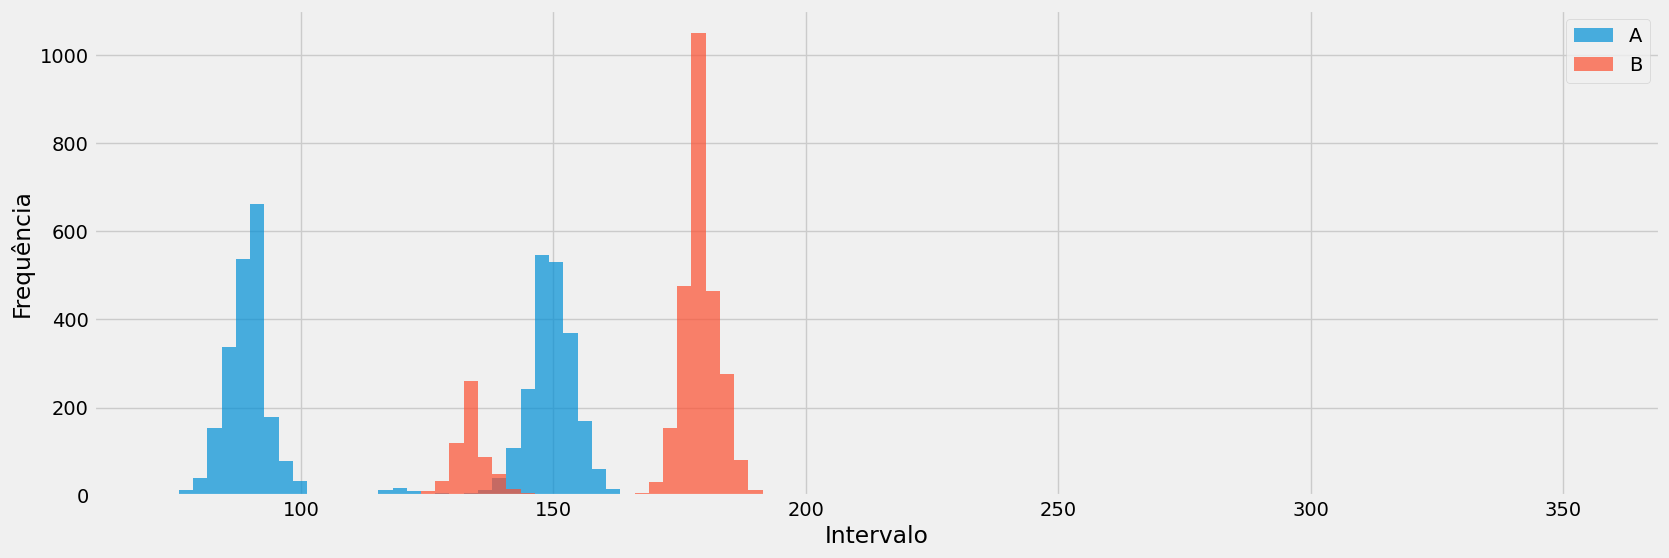

In [32]:
min_value = min(hb20_a["Interval"].min(), hb20_b["Interval"].min())
max_value = max(hb20_a["Interval"].max(), hb20_b["Interval"].max())

num_bins = 100
bins = np.linspace(min_value, max_value, num_bins + 1)

plt.figure(figsize=(18, 6))

plt.hist(hb20_a["Interval"], bins=bins, alpha=0.7, label="A")
plt.hist(hb20_b["Interval"], bins=bins, alpha=0.7, label="B")

plt.xlabel("Intervalo")
plt.ylabel("Frequência")

plt.legend(loc='upper right')

plt.show()

# General Plotting

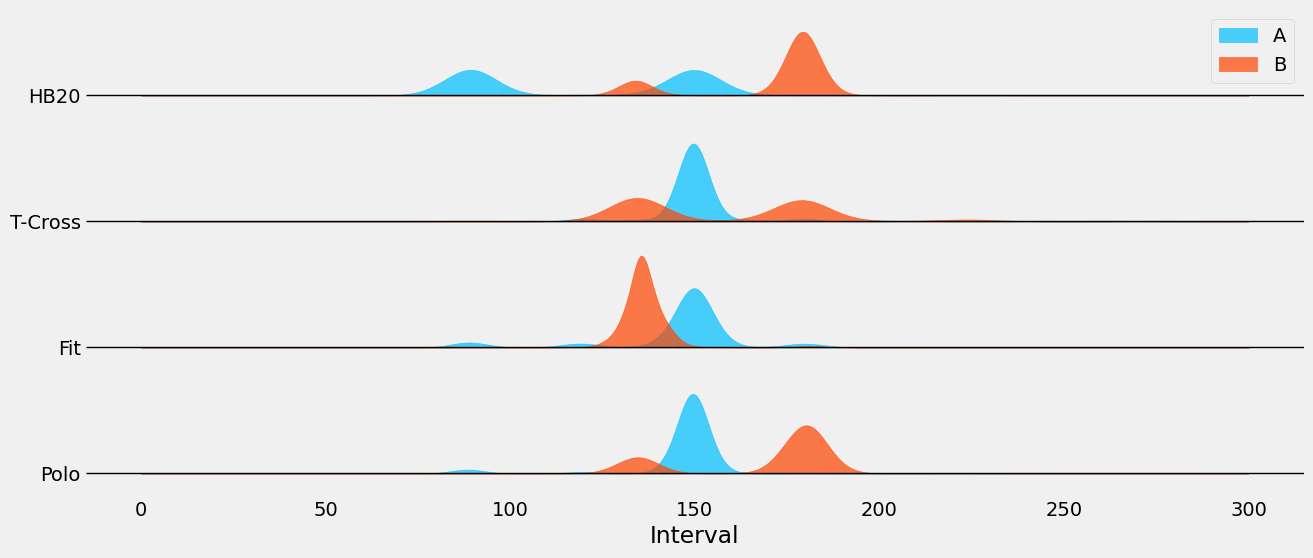

In [34]:
polo_a = {"Interval": polo_a["Interval"]}
polo_b = {"Interval": polo_b["Interval"]}
fit_a = {"Interval": fit_a["Interval"]}
fit_b = {"Interval": fit_b["Interval"]}
tcross_a = {"Interval": tcross_a["Interval"]}
tcross_b = {"Interval": tcross_b["Interval"]}
hb20_a = {"Interval": hb20_a["Interval"]}
hb20_b = {"Interval": hb20_b["Interval"]}
# fastback_a = {"Interval": fastback_a["Interval"]}
# fastback_b = {"Interval": fastback_b["Interval"]}

# cars = ["Polo", "Fit", "T-Cross", "Fastback"]
# cars = ["Polo", "Fit", "T-Cross"]
cars = ["Polo", "Fit", "T-Cross", "HB20"]
samples = [
    [polo_a["Interval"], polo_b["Interval"]],
    [fit_a["Interval"], fit_b["Interval"]],
    [tcross_a["Interval"], tcross_b["Interval"]],
    [hb20_a["Interval"], hb20_b["Interval"]],
    # [fastback_a["Interval"], fastback_b["Interval"]],
]

colors = ['deepskyblue', 'orangered']

plt.figure(figsize=(14, 6))

x_vals = np.linspace(0, 300, 400)

for i, car_samples in enumerate(samples):
    offset = i * 2
    
    for j, sample in enumerate(car_samples):
        kde = stats.gaussian_kde(sample, bw_method=0.2)
        density = kde(x_vals) * 15
        
        plt.fill_between(x_vals, density + offset, offset, color=colors[j % 2], alpha=0.7)
    
    plt.axhline(y=offset, color='black', linewidth=1)

plt.yticks([i * 2 for i in range(len(cars))], cars)
plt.grid(False)
plt.box(False)

plt.xlabel("Interval")
plt.legend(["A", "B"], loc="upper right")

plt.show()